In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mean_std_data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=transforms.ToTensor()).train_data.float() / 255
mean = torch.mean(mean_std_data)
std = torch.std(mean_std_data)
print(mean, std)
print(mean_std_data.shape)

tensor(0.2860) tensor(0.3530)
torch.Size([60000, 28, 28])


In [3]:
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
           ])

In [10]:
def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_transform, path='./FashionMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    train_data.train_data = train_data.train_data[:5000, :, :]
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [11]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=1000)
print(len(train_loader), len(valid_loader))

80 20


In [25]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(512)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc5(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [26]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [27]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    
    train_loss = {k: 0. for k in models}
    correct_train = {k: 0. for k in models}
    
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_loss[k] += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct_train[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
        if batch_idx % 20 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
    if log is not None:
        for k in models:
            train_loss[k] /= train_size
        correct_pct = {k: 100. * correct_train[k] / train_size for k in correct_train}
        for k in models:
            log[k].append((train_loss[k], correct_pct[k])) 

In [28]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [44]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000001 both: 0.000589
Train Epoch: 1 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000048 drop: 0.000000 both: 0.000045
Train Epoch: 1 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.000000 both: 0.000030
Train Epoch: 1 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000000 both: 0.000052
Train Epoch: 1 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000018 drop: 0.000000 both: 0.000688
Test set:
default: Loss: 1.5143	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.0815	Accuracy: 846.0/1000 (85%)
drop: Loss: 1.3173	Accuracy: 862.0/1000 (86%)
both: Loss: 1.1170	Accuracy: 865.0/1000 (86%)

Train Epoch: 2 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000029 drop: 0.000002 both: 0.000154
Train Epoch: 2 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000051 drop: 0.000001 both: 0.000017
Train Epoch: 2 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000001 both: 0.000036
Tra

Test set:
default: Loss: 1.5247	Accuracy: 854.0/1000 (85%)
bn: Loss: 1.1879	Accuracy: 846.0/1000 (85%)
drop: Loss: 1.3100	Accuracy: 858.0/1000 (86%)
both: Loss: 1.0539	Accuracy: 872.0/1000 (87%)

Train Epoch: 13 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000001 both: 0.000030
Train Epoch: 13 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.002156 drop: 0.000000 both: 0.000008
Train Epoch: 13 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000256 drop: 0.000000 both: 0.000030
Train Epoch: 13 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000457 drop: 0.000001 both: 0.000014
Train Epoch: 13 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000028 drop: 0.000000 both: 0.000008
Test set:
default: Loss: 1.5244	Accuracy: 854.0/1000 (85%)
bn: Loss: 1.0709	Accuracy: 854.0/1000 (85%)
drop: Loss: 1.3342	Accuracy: 863.0/1000 (86%)
both: Loss: 1.0622	Accuracy: 872.0/1000 (87%)

Train Epoch: 14 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.004543 drop: 0.000001 both: 0.000145
Tra

Train Epoch: 24 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000032 drop: 0.000000 both: 0.000006
Train Epoch: 24 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000026 drop: 0.000000 both: 0.000049
Test set:
default: Loss: 1.5312	Accuracy: 853.0/1000 (85%)
bn: Loss: 1.1539	Accuracy: 852.0/1000 (85%)
drop: Loss: 1.3222	Accuracy: 860.0/1000 (86%)
both: Loss: 1.1116	Accuracy: 866.0/1000 (87%)

Train Epoch: 25 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000018 drop: 0.000000 both: 0.000010
Train Epoch: 25 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000056 drop: 0.000000 both: 0.000739
Train Epoch: 25 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000035 drop: 0.000001 both: 0.000170
Train Epoch: 25 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000016 drop: 0.000000 both: 0.000018
Train Epoch: 25 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000000 both: 0.000009
Test set:
default: Loss: 1.5347	Accuracy: 853.0/1000 (85%)
bn: Loss: 1.0962	Accuracy: 863.0/

Train Epoch: 36 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000111 drop: 0.005945 both: 0.000345
Train Epoch: 36 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.011844 both: 0.000093
Train Epoch: 36 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.254558 both: 0.002103
Train Epoch: 36 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.001679 drop: 0.140261 both: 0.003421
Test set:
default: Loss: 1.5289	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.0918	Accuracy: 857.0/1000 (86%)
drop: Loss: 1.1085	Accuracy: 846.0/1000 (85%)
both: Loss: 1.1717	Accuracy: 858.0/1000 (86%)

Train Epoch: 37 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.029250 both: 0.000349
Train Epoch: 37 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.046238 drop: 0.020415 both: 0.000024
Train Epoch: 37 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000062 drop: 0.159197 both: 0.000051
Train Epoch: 37 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.011586 drop: 0.000194 both: 

Train Epoch: 48 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000079 drop: 0.000014 both: 0.000018
Train Epoch: 48 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000026 drop: 0.000067 both: 0.000032
Train Epoch: 48 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000183 drop: 0.000854 both: 0.000080
Train Epoch: 48 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.000563 both: 0.000479
Test set:
default: Loss: 1.5337	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.1024	Accuracy: 854.0/1000 (85%)
drop: Loss: 1.0576	Accuracy: 861.0/1000 (86%)
both: Loss: 1.1100	Accuracy: 859.0/1000 (86%)

Train Epoch: 49 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000055 drop: 0.000095 both: 0.000052
Train Epoch: 49 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000062 drop: 0.000010 both: 0.000040
Train Epoch: 49 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000345 drop: 0.000219 both: 0.000010
Train Epoch: 49 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.000019 both: 

Train Epoch: 60 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000064 drop: 0.000023 both: 0.000029
Train Epoch: 60 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000042 drop: 0.000118 both: 0.000006
Train Epoch: 60 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000079 drop: 0.000059 both: 0.000044
Train Epoch: 60 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.000007 both: 0.000030
Test set:
default: Loss: 1.5449	Accuracy: 850.0/1000 (85%)
bn: Loss: 1.0727	Accuracy: 858.0/1000 (86%)
drop: Loss: 1.0952	Accuracy: 867.0/1000 (87%)
both: Loss: 1.1103	Accuracy: 866.0/1000 (87%)

Train Epoch: 61 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000007 both: 0.000031
Train Epoch: 61 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000455 drop: 0.000017 both: 0.000090
Train Epoch: 61 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000030 drop: 0.000024 both: 0.000027
Train Epoch: 61 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.001440 drop: 0.000035 both: 

Train Epoch: 72 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000008 drop: 0.000006 both: 0.000053
Train Epoch: 72 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000002 both: 0.000061
Train Epoch: 72 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000024 both: 0.000010
Train Epoch: 72 [4000/4000 (100%)]	Losses default: 0.000000 bn: 0.000012 drop: 0.000007 both: 0.000026
Test set:
default: Loss: 1.5370	Accuracy: 851.0/1000 (85%)
bn: Loss: 1.0639	Accuracy: 854.0/1000 (85%)
drop: Loss: 1.1176	Accuracy: 864.0/1000 (86%)
both: Loss: 1.1452	Accuracy: 852.0/1000 (85%)

Train Epoch: 73 [0/4000 (0%)]	Losses default: 0.000000 bn: 0.000311 drop: 0.000010 both: 0.001622
Train Epoch: 73 [1000/4000 (25%)]	Losses default: 0.000000 bn: 0.000042 drop: 0.000010 both: 0.000010
Train Epoch: 73 [2000/4000 (50%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000003 both: 0.000011
Train Epoch: 73 [3000/4000 (75%)]	Losses default: 0.000000 bn: 0.001603 drop: 0.000031 both: 

Train Epoch: 84 [1000/4000 (25%)]	Losses default: 0.014090 bn: 0.013703 drop: 0.000013 both: 0.000389
Train Epoch: 84 [2000/4000 (50%)]	Losses default: 0.001102 bn: 0.000123 drop: 0.000015 both: 0.000061
Train Epoch: 84 [3000/4000 (75%)]	Losses default: 0.002711 bn: 0.000086 drop: 0.000017 both: 0.000032
Train Epoch: 84 [4000/4000 (100%)]	Losses default: 0.001985 bn: 0.000070 drop: 0.000006 both: 0.000052
Test set:
default: Loss: 0.9508	Accuracy: 856.0/1000 (86%)
bn: Loss: 1.0569	Accuracy: 862.0/1000 (86%)
drop: Loss: 1.1331	Accuracy: 866.0/1000 (87%)
both: Loss: 1.1191	Accuracy: 856.0/1000 (86%)

Train Epoch: 85 [0/4000 (0%)]	Losses default: 0.010240 bn: 0.000343 drop: 0.000004 both: 0.000029
Train Epoch: 85 [1000/4000 (25%)]	Losses default: 0.007010 bn: 0.000038 drop: 0.000050 both: 0.000052
Train Epoch: 85 [2000/4000 (50%)]	Losses default: 0.002002 bn: 0.000051 drop: 0.000026 both: 0.000027
Train Epoch: 85 [3000/4000 (75%)]	Losses default: 0.011661 bn: 0.000039 drop: 0.000005 both: 

Train Epoch: 96 [1000/4000 (25%)]	Losses default: 0.000099 bn: 0.000051 drop: 0.000007 both: 0.000115
Train Epoch: 96 [2000/4000 (50%)]	Losses default: 0.000147 bn: 0.000064 drop: 0.000007 both: 0.000015
Train Epoch: 96 [3000/4000 (75%)]	Losses default: 0.000173 bn: 0.000050 drop: 0.000006 both: 0.000031
Train Epoch: 96 [4000/4000 (100%)]	Losses default: 0.000082 bn: 0.000007 drop: 0.000011 both: 0.000034
Test set:
default: Loss: 1.0560	Accuracy: 857.0/1000 (86%)
bn: Loss: 1.0668	Accuracy: 861.0/1000 (86%)
drop: Loss: 1.1603	Accuracy: 863.0/1000 (86%)
both: Loss: 1.1285	Accuracy: 865.0/1000 (86%)

Train Epoch: 97 [0/4000 (0%)]	Losses default: 0.000044 bn: 0.000010 drop: 0.000011 both: 0.000015
Train Epoch: 97 [1000/4000 (25%)]	Losses default: 0.000034 bn: 0.000014 drop: 0.000002 both: 0.000012
Train Epoch: 97 [2000/4000 (50%)]	Losses default: 0.000142 bn: 0.000045 drop: 0.000007 both: 0.000702
Train Epoch: 97 [3000/4000 (75%)]	Losses default: 0.000093 bn: 0.000019 drop: 0.000002 both: 

Train Epoch: 108 [1000/4000 (25%)]	Losses default: 0.000064 bn: 0.000090 drop: 0.000002 both: 0.000005
Train Epoch: 108 [2000/4000 (50%)]	Losses default: 0.000044 bn: 0.000018 drop: 0.000005 both: 0.000007
Train Epoch: 108 [3000/4000 (75%)]	Losses default: 0.000107 bn: 0.000017 drop: 0.000002 both: 0.000084
Train Epoch: 108 [4000/4000 (100%)]	Losses default: 0.000069 bn: 0.000027 drop: 0.000016 both: 0.000009
Test set:
default: Loss: 1.1185	Accuracy: 858.0/1000 (86%)
bn: Loss: 1.0536	Accuracy: 863.0/1000 (86%)
drop: Loss: 1.1697	Accuracy: 860.0/1000 (86%)
both: Loss: 1.1652	Accuracy: 861.0/1000 (86%)

Train Epoch: 109 [0/4000 (0%)]	Losses default: 0.000027 bn: 0.000377 drop: 0.000006 both: 0.000018
Train Epoch: 109 [1000/4000 (25%)]	Losses default: 0.000036 bn: 0.000038 drop: 0.000005 both: 0.000006
Train Epoch: 109 [2000/4000 (50%)]	Losses default: 0.000089 bn: 0.019180 drop: 0.000007 both: 0.000005
Train Epoch: 109 [3000/4000 (75%)]	Losses default: 0.000044 bn: 0.003634 drop: 0.00000

Test set:
default: Loss: 1.1578	Accuracy: 856.0/1000 (86%)
bn: Loss: 1.0256	Accuracy: 858.0/1000 (86%)
drop: Loss: 1.1834	Accuracy: 868.0/1000 (87%)
both: Loss: 1.2044	Accuracy: 850.0/1000 (85%)

Train Epoch: 120 [0/4000 (0%)]	Losses default: 0.000040 bn: 0.000010 drop: 0.000011 both: 0.000368
Train Epoch: 120 [1000/4000 (25%)]	Losses default: 0.000030 bn: 0.000038 drop: 0.000008 both: 0.000018
Train Epoch: 120 [2000/4000 (50%)]	Losses default: 0.000014 bn: 0.000118 drop: 0.000003 both: 0.000068
Train Epoch: 120 [3000/4000 (75%)]	Losses default: 0.000020 bn: 0.026077 drop: 0.000019 both: 0.063967
Train Epoch: 120 [4000/4000 (100%)]	Losses default: 0.000020 bn: 0.000012 drop: 0.000002 both: 0.004394
Test set:
default: Loss: 1.1604	Accuracy: 857.0/1000 (86%)
bn: Loss: 1.0532	Accuracy: 853.0/1000 (85%)
drop: Loss: 1.1814	Accuracy: 863.0/1000 (86%)
both: Loss: 1.1359	Accuracy: 856.0/1000 (86%)

Train Epoch: 121 [0/4000 (0%)]	Losses default: 0.000012 bn: 0.000021 drop: 0.000001 both: 0.0000

Train Epoch: 131 [3000/4000 (75%)]	Losses default: 0.000016 bn: 0.000100 drop: 0.000002 both: 0.000324
Train Epoch: 131 [4000/4000 (100%)]	Losses default: 0.000018 bn: 0.000123 drop: 0.000006 both: 0.000146
Test set:
default: Loss: 1.1911	Accuracy: 855.0/1000 (86%)
bn: Loss: 1.0913	Accuracy: 871.0/1000 (87%)
drop: Loss: 1.2388	Accuracy: 860.0/1000 (86%)
both: Loss: 1.2262	Accuracy: 854.0/1000 (85%)

Train Epoch: 132 [0/4000 (0%)]	Losses default: 0.000006 bn: 0.000026 drop: 0.000006 both: 0.000035
Train Epoch: 132 [1000/4000 (25%)]	Losses default: 0.000029 bn: 0.000101 drop: 0.000003 both: 0.001712
Train Epoch: 132 [2000/4000 (50%)]	Losses default: 0.000011 bn: 0.000012 drop: 0.000002 both: 0.000089
Train Epoch: 132 [3000/4000 (75%)]	Losses default: 0.000026 bn: 0.000012 drop: 0.000002 both: 0.000174
Train Epoch: 132 [4000/4000 (100%)]	Losses default: 0.000006 bn: 0.000016 drop: 0.000001 both: 0.000132
Test set:
default: Loss: 1.1943	Accuracy: 853.0/1000 (85%)
bn: Loss: 1.0878	Accuracy:

Train Epoch: 143 [1000/4000 (25%)]	Losses default: 0.000004 bn: 0.000213 drop: 0.000006 both: 0.000026
Train Epoch: 143 [2000/4000 (50%)]	Losses default: 0.000013 bn: 0.000073 drop: 0.000002 both: 0.000034
Train Epoch: 143 [3000/4000 (75%)]	Losses default: 0.000017 bn: 0.000131 drop: 0.000002 both: 0.000042
Train Epoch: 143 [4000/4000 (100%)]	Losses default: 0.000009 bn: 0.000250 drop: 0.000001 both: 0.000017
Test set:
default: Loss: 1.2217	Accuracy: 858.0/1000 (86%)
bn: Loss: 1.0753	Accuracy: 859.0/1000 (86%)
drop: Loss: 1.2301	Accuracy: 865.0/1000 (86%)
both: Loss: 1.1758	Accuracy: 854.0/1000 (85%)

Train Epoch: 144 [0/4000 (0%)]	Losses default: 0.000005 bn: 0.000035 drop: 0.000002 both: 0.000057
Train Epoch: 144 [1000/4000 (25%)]	Losses default: 0.000008 bn: 0.000115 drop: 0.000003 both: 0.000080
Train Epoch: 144 [2000/4000 (50%)]	Losses default: 0.000017 bn: 0.000012 drop: 0.000006 both: 0.000066
Train Epoch: 144 [3000/4000 (75%)]	Losses default: 0.000005 bn: 0.000200 drop: 0.00000

Test set:
default: Loss: 1.2474	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.1399	Accuracy: 857.0/1000 (86%)
drop: Loss: 1.2764	Accuracy: 860.0/1000 (86%)
both: Loss: 1.1314	Accuracy: 863.0/1000 (86%)

Train Epoch: 155 [0/4000 (0%)]	Losses default: 0.000002 bn: 0.000069 drop: 0.000001 both: 0.000020
Train Epoch: 155 [1000/4000 (25%)]	Losses default: 0.000009 bn: 0.000346 drop: 0.000001 both: 0.000009
Train Epoch: 155 [2000/4000 (50%)]	Losses default: 0.000009 bn: 0.000018 drop: 0.000005 both: 0.000045
Train Epoch: 155 [3000/4000 (75%)]	Losses default: 0.000002 bn: 0.000015 drop: 0.000001 both: 0.000010
Train Epoch: 155 [4000/4000 (100%)]	Losses default: 0.000007 bn: 0.000018 drop: 0.000001 both: 0.000067
Test set:
default: Loss: 1.2498	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.1299	Accuracy: 862.0/1000 (86%)
drop: Loss: 1.2554	Accuracy: 864.0/1000 (86%)
both: Loss: 1.1642	Accuracy: 861.0/1000 (86%)

Train Epoch: 156 [0/4000 (0%)]	Losses default: 0.000003 bn: 0.000070 drop: 0.000001 both: 0.0000

Train Epoch: 166 [3000/4000 (75%)]	Losses default: 0.000006 bn: 0.000004 drop: 0.000001 both: 0.000017
Train Epoch: 166 [4000/4000 (100%)]	Losses default: 0.000003 bn: 0.000005 drop: 0.000000 both: 0.000027
Test set:
default: Loss: 1.2731	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.1028	Accuracy: 867.0/1000 (87%)
drop: Loss: 1.2682	Accuracy: 867.0/1000 (87%)
both: Loss: 1.1239	Accuracy: 871.0/1000 (87%)

Train Epoch: 167 [0/4000 (0%)]	Losses default: 0.000004 bn: 0.000069 drop: 0.000002 both: 0.000019
Train Epoch: 167 [1000/4000 (25%)]	Losses default: 0.000008 bn: 0.000021 drop: 0.000002 both: 0.018992
Train Epoch: 167 [2000/4000 (50%)]	Losses default: 0.000007 bn: 0.000055 drop: 0.000003 both: 0.001309
Train Epoch: 167 [3000/4000 (75%)]	Losses default: 0.000004 bn: 0.000014 drop: 0.000000 both: 0.000013
Train Epoch: 167 [4000/4000 (100%)]	Losses default: 0.000002 bn: 0.000011 drop: 0.000001 both: 0.000020
Test set:
default: Loss: 1.2755	Accuracy: 852.0/1000 (85%)
bn: Loss: 1.1061	Accuracy:

Train Epoch: 178 [1000/4000 (25%)]	Losses default: 0.000002 bn: 0.000005 drop: 0.000000 both: 0.000024
Train Epoch: 178 [2000/4000 (50%)]	Losses default: 0.000004 bn: 0.000013 drop: 0.000001 both: 0.000060
Train Epoch: 178 [3000/4000 (75%)]	Losses default: 0.000003 bn: 0.000056 drop: 0.000002 both: 0.000012
Train Epoch: 178 [4000/4000 (100%)]	Losses default: 0.000003 bn: 0.000026 drop: 0.000000 both: 0.000101
Test set:
default: Loss: 1.2993	Accuracy: 855.0/1000 (86%)
bn: Loss: 1.1556	Accuracy: 861.0/1000 (86%)
drop: Loss: 1.2904	Accuracy: 867.0/1000 (87%)
both: Loss: 1.1417	Accuracy: 855.0/1000 (86%)

Train Epoch: 179 [0/4000 (0%)]	Losses default: 0.000002 bn: 0.000019 drop: 0.000001 both: 0.000029
Train Epoch: 179 [1000/4000 (25%)]	Losses default: 0.000004 bn: 0.000005 drop: 0.000001 both: 0.000009
Train Epoch: 179 [2000/4000 (50%)]	Losses default: 0.000004 bn: 0.000009 drop: 0.000001 both: 0.003631
Train Epoch: 179 [3000/4000 (75%)]	Losses default: 0.000004 bn: 0.000007 drop: 0.00000

Test set:
default: Loss: 1.3220	Accuracy: 854.0/1000 (85%)
bn: Loss: 1.0534	Accuracy: 868.0/1000 (87%)
drop: Loss: 1.3087	Accuracy: 868.0/1000 (87%)
both: Loss: 1.1633	Accuracy: 864.0/1000 (86%)

Train Epoch: 190 [0/4000 (0%)]	Losses default: 0.000004 bn: 0.000100 drop: 0.000001 both: 0.000028
Train Epoch: 190 [1000/4000 (25%)]	Losses default: 0.000002 bn: 0.000043 drop: 0.000000 both: 0.001418
Train Epoch: 190 [2000/4000 (50%)]	Losses default: 0.000003 bn: 0.000308 drop: 0.000001 both: 0.000006
Train Epoch: 190 [3000/4000 (75%)]	Losses default: 0.000002 bn: 0.001860 drop: 0.000001 both: 0.000697
Train Epoch: 190 [4000/4000 (100%)]	Losses default: 0.000002 bn: 0.192015 drop: 0.000000 both: 0.000005
Test set:
default: Loss: 1.3238	Accuracy: 853.0/1000 (85%)
bn: Loss: 1.0401	Accuracy: 862.0/1000 (86%)
drop: Loss: 1.2833	Accuracy: 864.0/1000 (86%)
both: Loss: 1.1646	Accuracy: 860.0/1000 (86%)

Train Epoch: 191 [0/4000 (0%)]	Losses default: 0.000001 bn: 0.000163 drop: 0.000000 both: 0.0030

In [30]:
def plot_compare_logs(test_log, train_log):
    keys = test_log.keys()
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    epochs = {k:range(len(test_log[k])) for k in keys}
    
    g_counter = 0
    for k in keys:        
        plt.subplot(4, 2, g_counter+1)
        plt.plot(epochs[k], test_logs[k][0], label='test loss')
        plt.plot(epochs[k], train_logs[k][0], label='train loss')
        plt.title(k + ' errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        plt.subplot(4, 2, g_counter+2)
        plt.plot(epochs[k], test_logs[k][1], label='test accuracy')
        plt.plot(epochs[k], train_logs[k][1], label='train accuracy')
        plt.title(k + ' accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        g_counter += 2

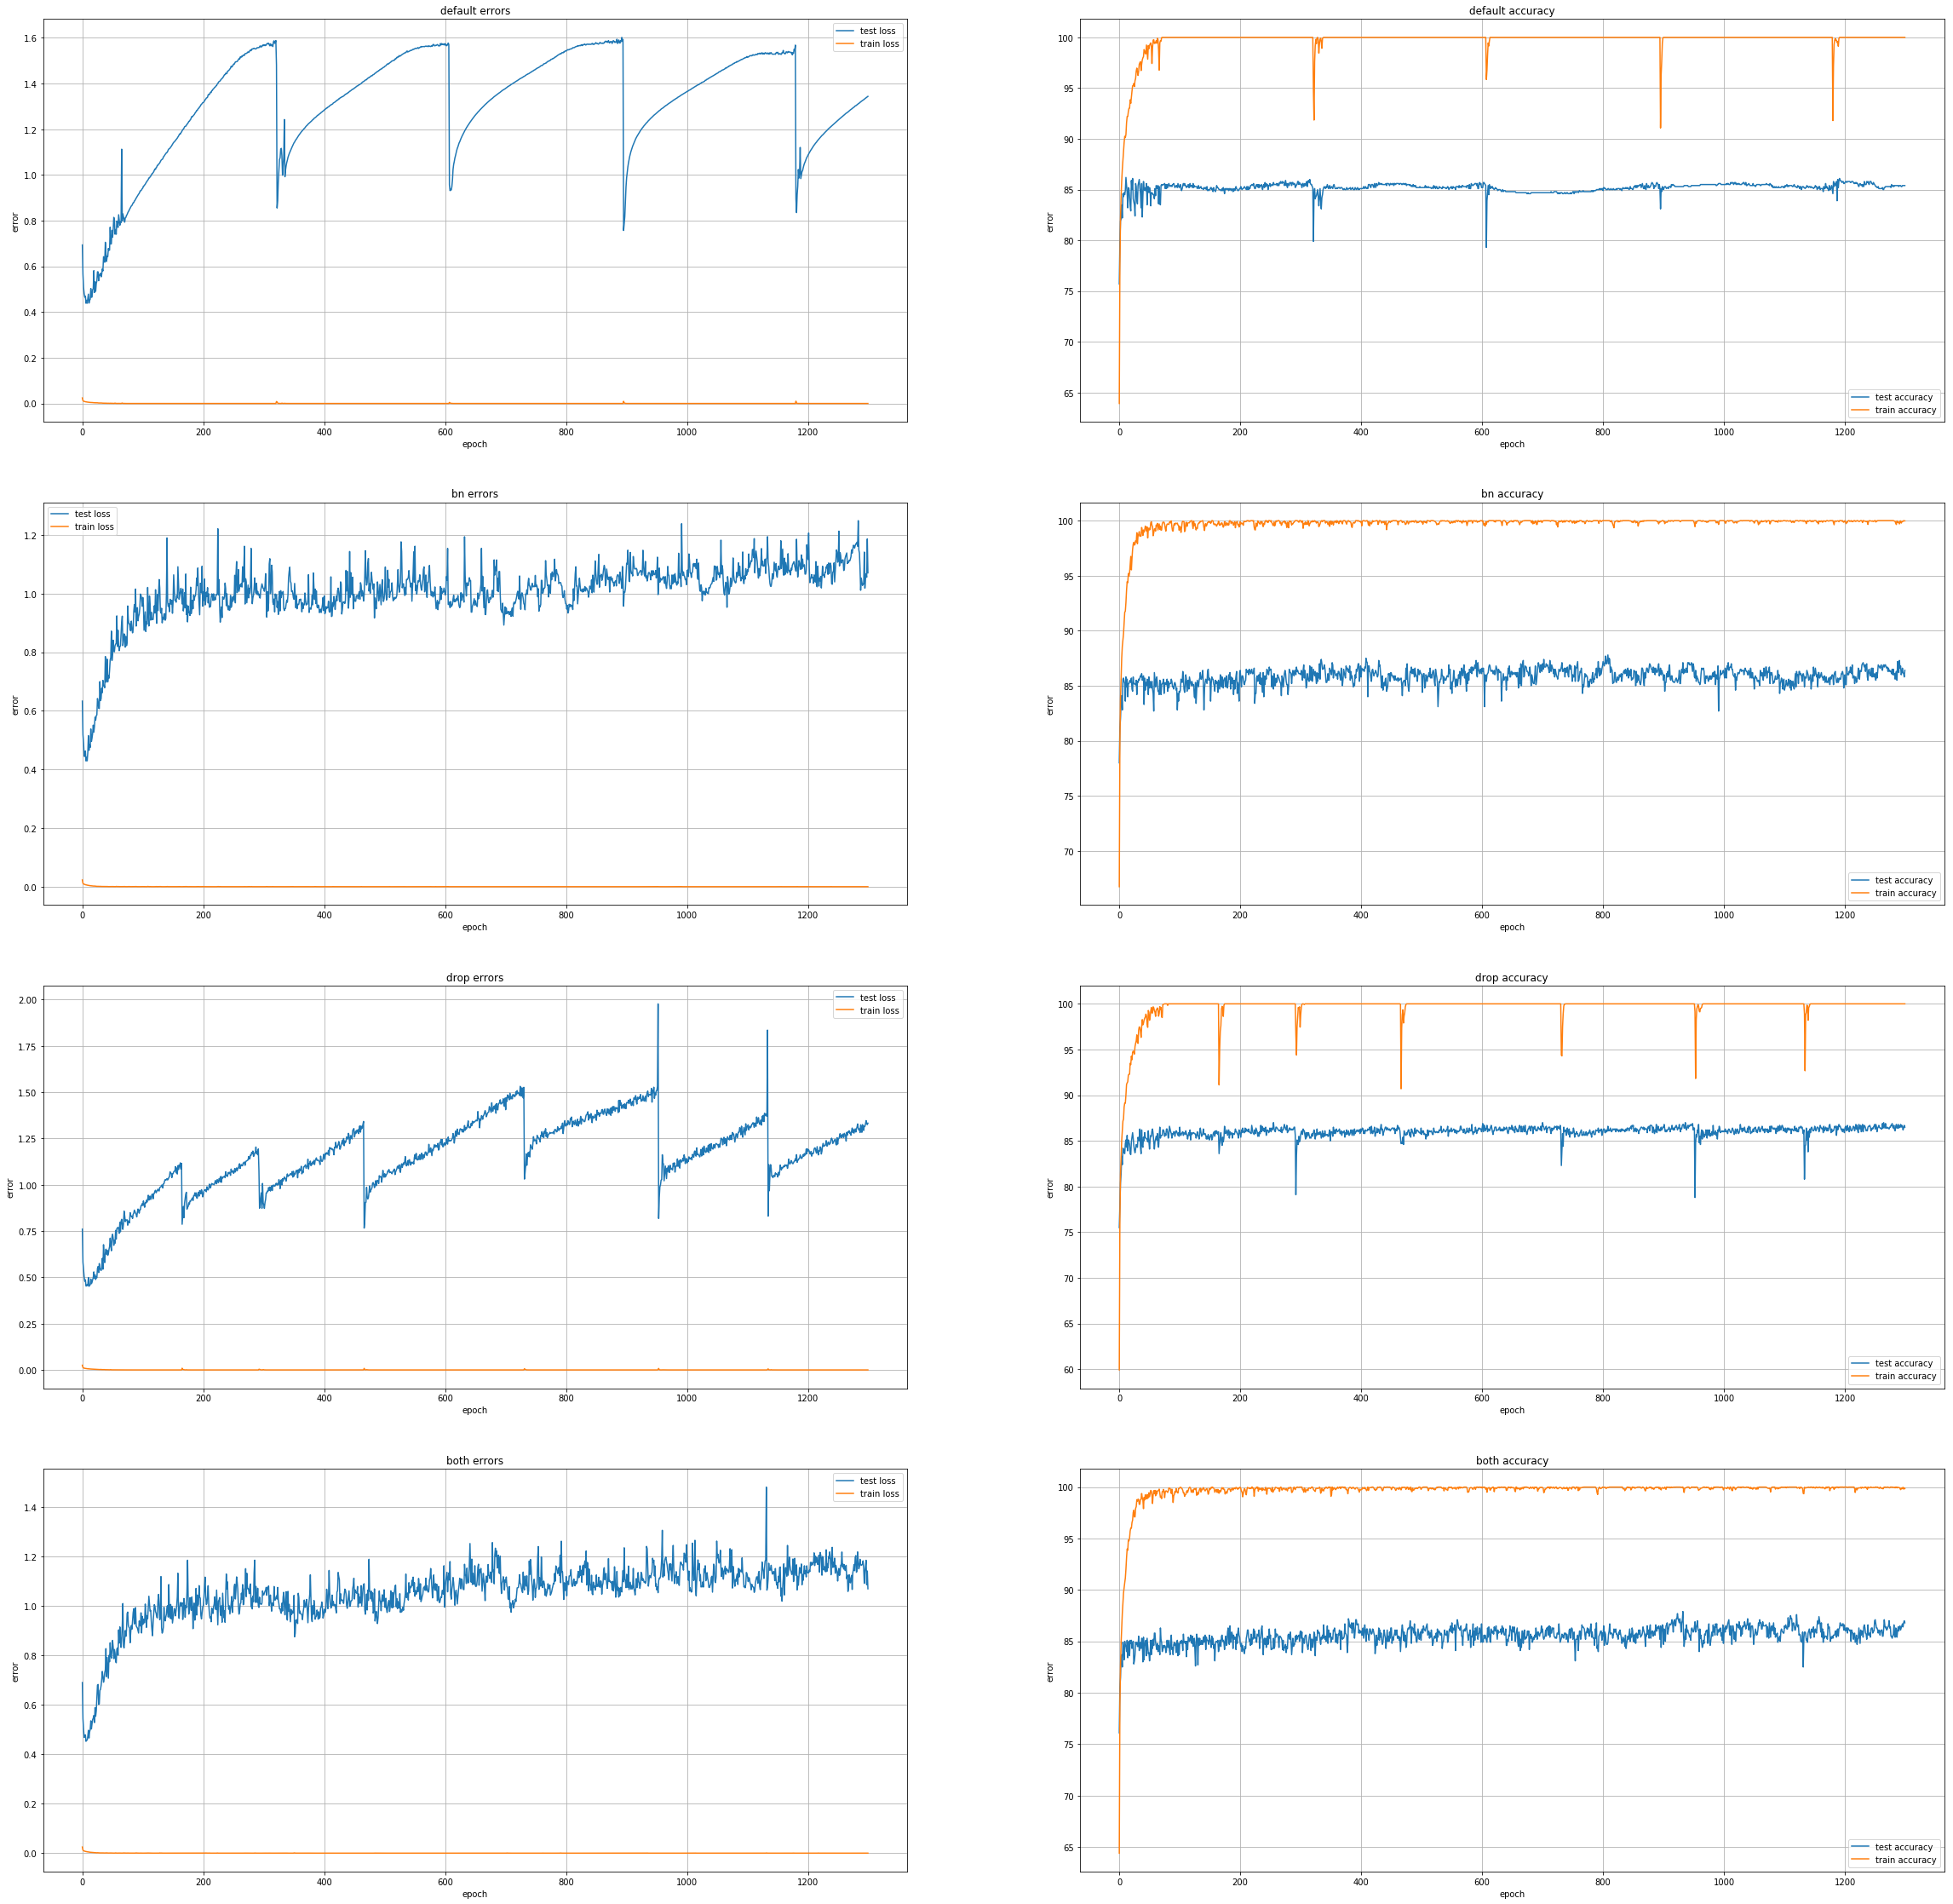

In [45]:
plt.rcParams['figure.figsize'] = [40, 40]
plot_compare_logs(test_log, train_log)